In [3]:
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("DifferentialEquations")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
Precompiling project...


In [1]:
#using ForwardDiff
using LinearAlgebra
using Plots
using DifferentialEquations: ODEProblem, RK4, solve

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1342


In [2]:
m = 0.2
c = 0.5
function point_mass!(dx, x, u, t)
    dx[1] = x[2]                #x_1 = ẋ
    dx[2] = -(c/m)*x[2] + u(t, x)/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    # dx[3] = x[3]
    # dx[4] = -(c/m)*x[3] + u(t)/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m
end

point_mass! (generic function with 1 method)

In [405]:
function point_mass_2D!(dx, x, u, t)
    dx[1] = x[2]                #x_1 = ẋ
    dx[2] = -(c/m)*x[2] + u(t, x)/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    dx[3] = x[4]
    dx[4] = -(c/m)*x[4] + u(t,x)/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m
end

point_mass_2D! (generic function with 1 method)

In [3]:
dt = 0.01
A = [0 1; 0 -c/m]
B = [0; 1/m]
Ad = dt .* A + I #discrete
Bd = dt .*B #discrete
function lqr!(T)
    Q = 10.0*I#[0.5 0; 0 0.3]
    R = 1.0*I#[0.5]
    V = copy(Q)
    #println(T[1])
    T[1] = T[1] - 1
    K = zeros(T[1], 2)

    for i in 1:T[1]
        K_i = -inv(R + transpose(Bd) * V * Bd) * transpose(Bd) * V * Ad
        V = Q + transpose(K_i) * R * K_i + transpose(Ad + Bd * K_i) * V * (Ad + Bd * K_i)
        K[i, :] = K_i
    end
    #println("lqr..")
    return K
end


lqr! (generic function with 1 method)

In [5]:
#lqr!(10)#[end,:]
tf = 15.0
t = Array(range(0, tf, step=0.01))
length(t)
T_all = [1500]

1-element Vector{Int64}:
 1500

In [12]:
x_ref(t) = if (t > 1)
    return [t*0.0 + 0.10, 0.0]
else
    return [t*0.0, 0.0]
end
tf = 15.0
tspan = (0.0,tf)                  # time interval
x₀ = [0; 0]                       # initial Condition
#K = -2.0                     # proportional gain
U = (t,x) -> lqr!(T_all)[end,1]*(x - x_ref(t))[1]

prob = ODEProblem(point_mass!,x₀, tspan, U)
sol = solve(prob, RK4(), dt=0.01, adaptive=true);

LoadError: BoundsError: attempt to access 0×2 Matrix{Float64} at index [0, 1]

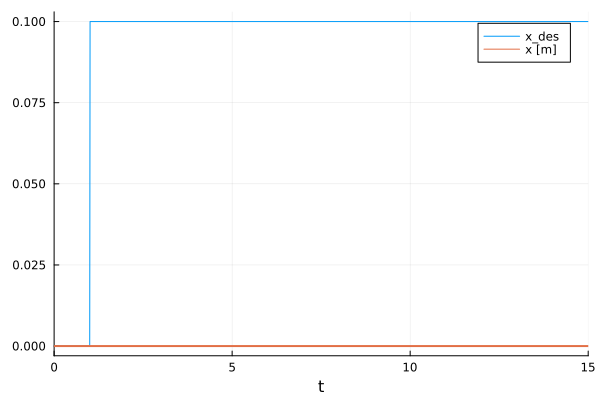

In [11]:
t = Array(range(0, tf, step=0.01))
fxs = x_ref.(t) # gives a vector of tuples
fxs1 = [x[1] for x in fxs] # extract each component
plot(t, fxs1, label="x_des")
plot!(sol,linewidth=2,xaxis="t",label=["x [m]" "ẋ [m/s]"], idxs=(0,1))#,layout=(2,1))

In [242]:
sol(100)[1]

0.18342186722544168

┌ Info: Saved animation to /Users/mohsafwat/Desktop/PHD2022/Autumn/CS_project/RK4.gif
└ @ Plots /Users/mohsafwat/.julia/packages/Plots/aRJ6C/src/animation.jl:149


Plots.AnimatedGif("/Users/mohsafwat/Desktop/PHD2022/Autumn/CS_project/RK4.gif")
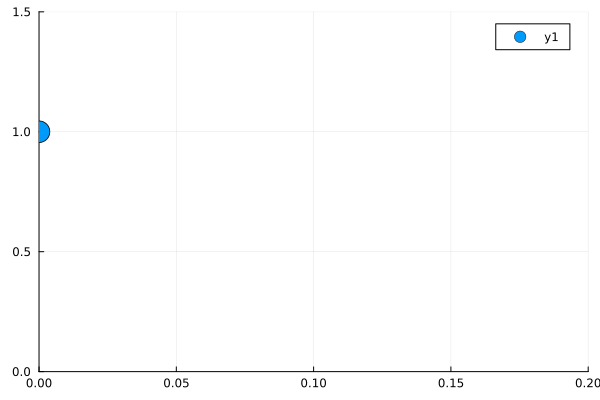

In [376]:
anim = @animate for i in (t)
    scatter([sol(i)[1]], [1], m = (:circle, 12),
    xlims = (0.0, 0.2), 
    ylims = (0, 1.5), )
end every 10;
gif(anim, "RK4.gif")
